# Garden temperature vs online weather data temperature report


## Introduction
This analysis aims to address the following questions:

- What is the difference between the measured (garden) and predicted (from the weather server; for Nordwijk) temperature?
- Do the other weather variables contribute to garden temperature being different than weather server temperature?

In order to start the analysis, garden sensor data was accessed by importing the smartthings data with the following command:
`python3 smartthings.py --rawinsert 'sqlite:///myhome.db' 'data/smartthings/smartthings.*'`
however the online weather data has only been accessed once the date range of the garden sensor data was known, which was done with:
`python3 openweathermap.py -d sqlite:///myhome.db 2022-12-23 2024-04-22`

In [1]:
import sqlalchemy as sa
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.linear_model import LinearRegression
from home_messages_db import HomeMessagesDB

In [2]:
db = HomeMessagesDB('sqlite:///myhome.db')
sql = "SELECT * FROM smartthings_RAW WHERE loc = 'garden'"
garden_df = db.query(stmt = sql, as_df = True, rawSQL = True)
garden_df.dropna(axis=0, inplace=True)
garden_df


,loc,level,name,time,capability,attribute,value,unit
34,garden,ground,garden (above),1671528680,powerMeter,power,0,W
36,garden,ground,garden (above),1671528735,powerMeter,power,0.6,W
38,garden,ground,garden (above),1671528761,powerMeter,power,0,W
44,garden,ground,garden (above),1671550269,powerMeter,power,0.6,W
46,garden,ground,garden (above),1671554275,powerMeter,power,0,W
...,...,...,...,...,...,...,...,...
433391,garden,ground,garden air (sensor),1713770611,illuminanceMeasurement,illuminance,989,lux
433392,garden,ground,garden air (sensor),1713770621,illuminanceMeasurement,illuminance,1139,lux
433393,garden,ground,garden air (sensor),1713770631,illuminanceMeasurement,illuminance,1255,lux
433394,garden,ground,garden air (sensor),1713770641,illuminanceMeasurement,illuminance,1412,lux


The values of the categorical variables `name` and `attribute` are explored to get the data on garden air temperature specifically:

In [3]:
print(garden_df['name'].unique())

['garden (above)' 'shed (sensor)' 'garden air (sensor)' 'kitchen (fridge)']


In [4]:
print(garden_df['attribute'].unique())

['power' 'energy' 'humidity' 'temperature' 'illuminance']


In [5]:
garden_air = garden_df[garden_df['name'] == 'garden air (sensor)']
garden_air = garden_air[garden_air['attribute'] == 'temperature']
garden_air = garden_air.rename({'time': 'unixtime'}, axis = 'columns')

garden_air['datetime'] = pd.to_datetime(garden_air['unixtime'],unit='s')
garden_air['month'] = pd.to_datetime(garden_air['datetime']).dt.month
garden_air['year'] = pd.to_datetime(garden_air['datetime']).dt.year

garden_air

,loc,level,name,unixtime,capability,attribute,value,unit,datetime,month,year
240,garden,ground,garden air (sensor),1671837628,temperatureMeasurement,temperature,9.2,°C,2022-12-23 23:20:28,12,2022
244,garden,ground,garden air (sensor),1671838182,temperatureMeasurement,temperature,9.3,°C,2022-12-23 23:29:42,12,2022
246,garden,ground,garden air (sensor),1671838736,temperatureMeasurement,temperature,9.1,°C,2022-12-23 23:38:56,12,2022
250,garden,ground,garden air (sensor),1671839843,temperatureMeasurement,temperature,9,°C,2022-12-23 23:57:23,12,2022
254,garden,ground,garden air (sensor),1671840397,temperatureMeasurement,temperature,8.8,°C,2022-12-24 00:06:37,12,2022
...,...,...,...,...,...,...,...,...,...,...,...
433365,garden,ground,garden air (sensor),1713765991,temperatureMeasurement,temperature,5.1,°C,2024-04-22 06:06:31,4,2024
433369,garden,ground,garden air (sensor),1713766544,temperatureMeasurement,temperature,5.6,°C,2024-04-22 06:15:44,4,2024
433371,garden,ground,garden air (sensor),1713767098,temperatureMeasurement,temperature,6.1,°C,2024-04-22 06:24:58,4,2024
433375,garden,ground,garden air (sensor),1713767836,temperatureMeasurement,temperature,6.5,°C,2024-04-22 06:37:16,4,2024


In [6]:
garden_air = garden_air.astype({'value': 'float'})

garden_air_temp = garden_air.groupby(["year", "month"])[["value"]].mean()
garden_air_temp


value
year month           
2022 12      7.691233
2023 1       5.658905
     2       6.315079
     3       7.300399
     4      10.542215
     5      15.153261
     6      22.339080
     7      19.762844
     8      18.943090
     9      21.617424
     10     13.461332
     11      8.341631
     12      6.997864
2024 1       4.406802
     2       8.266185
     3       9.876665
     4      11.981720

The mean values of the garden air temperatures have been calculated and grouped by month of occurrence. Now it is time to import the weather data, but first, let's check the range of the dates in the garden_air dataset to import weather data from the same period of time.

In [7]:
min_date = garden_air['datetime'].min()
max_date = garden_air['datetime'].max()

print('Minimum date:', min_date)
print('Maximum date:', max_date)

Minimum date: 2022-12-23 23:20:28
Maximum date: 2024-04-22 07:11:06


In [8]:
sql = "SELECT * FROM openweathermap"
weather_df = db.query(stmt = sql, as_df = True, rawSQL = True)

weather_df['datetime'] = pd.to_datetime(weather_df['unixtime'],unit='s')
weather_df['month'] = pd.to_datetime(weather_df['datetime']).dt.month
weather_df['year'] = pd.to_datetime(weather_df['datetime']).dt.year

weather_df


,date,temperature_2m_°C,relativehumidity_2m_%,rain_mm,snowfall_cm,windspeed_10m_km/h,winddirection_10m_°,soil_temperature_0_to_7cm_°C,unixtime,datetime,month,year
0,2022-12-23 00:00:00.000000,8.85,96.020897,0.0,0.0,13.755580,276.008911,8.25,1671753600,2022-12-23 00:00:00,12,2022
1,2022-12-23 01:00:00.000000,9.20,95.707397,0.0,0.0,12.605142,271.636536,8.10,1671757200,2022-12-23 01:00:00,12,2022
2,2022-12-23 02:00:00.000000,8.90,96.022453,0.0,0.0,11.165805,271.847565,7.85,1671760800,2022-12-23 02:00:00,12,2022
3,2022-12-23 03:00:00.000000,9.00,96.025536,0.0,0.0,9.064569,276.842682,7.90,1671764400,2022-12-23 03:00:00,12,2022
4,2022-12-23 04:00:00.000000,8.65,96.997643,0.0,0.0,6.763786,295.201080,7.80,1671768000,2022-12-23 04:00:00,12,2022
...,...,...,...,...,...,...,...,...,...,...,...,...
11683,2024-04-22 19:00:00.000000,5.35,65.731255,0.0,0.0,14.168641,27.216026,8.00,1713812400,2024-04-22 19:00:00,4,2024
11684,2024-04-22 20:00:00.000000,4.65,66.297638,0.0,0.0,14.081477,32.471172,7.15,1713816000,2024-04-22 20:00:00,4,2024
11685,2024-04-22 21:00:00.000000,3.95,63.746510,0.0,0.0,12.313894,37.875042,6.40,1713819600,2024-04-22 21:00:00,4,2024
11686,2024-04-22 22:00:00.000000,3.35,65.036377,0.0,0.0,11.609651,29.744795,5.75,1713823200,2024-04-22 22:00:00,4,2024


In [9]:
weather_temp = weather_df.groupby(["year", "month"])[["temperature_2m_°C"]].mean()
weather_temp


temperature_2m_°C
year month                   
2022 12              8.792361
2023 1               5.929503
     2               5.736458
     3               6.745699
     4               8.344444
     5              12.606116
     6              18.770347
     7              17.793145
     8              17.509677
     9              18.064861
     10             13.650605
     11              8.320625
     12              6.966599
2024 1               4.436694
     2               7.936566
     3               8.438911
     4              10.545549

In [10]:
temp_diff = pd.concat([garden_air_temp, weather_temp], axis=1, join='outer')
temp_diff['Temp_diff'] = temp_diff['value'] - temp_diff['temperature_2m_°C']
temp_diff = temp_diff.rename({'value': 'Garden_temp', 'temperature_2m_°C': 'Weather_temp'}, axis = 'columns')
temp_diff.insert(0, "Date", ['2022-12-01', '2023-01-01', '2023-02-01', '2023-03-01', '2023-04-01', '2023-05-01', '2023-06-01', '2023-07-01', '2023-08-01', '2023-09-01', '2023-10-01', '2023-11-01', '2023-12-01', '2024-01-01', '2024-02-01', '2024-03-01', '2024-04-01'], True)
temp_diff['Date'] = pd.to_datetime(temp_diff['Date'])
temp_diff

Date  Garden_temp  Weather_temp  Temp_diff
year month                                                 
2022 12    2022-12-01     7.691233      8.792361  -1.101128
2023 1     2023-01-01     5.658905      5.929503  -0.270598
     2     2023-02-01     6.315079      5.736458   0.578620
     3     2023-03-01     7.300399      6.745699   0.554700
     4     2023-04-01    10.542215      8.344444   2.197771
     5     2023-05-01    15.153261     12.606116   2.547146
     6     2023-06-01    22.339080     18.770347   3.568733
     7     2023-07-01    19.762844     17.793145   1.969699
     8     2023-08-01    18.943090     17.509677   1.433413
     9     2023-09-01    21.617424     18.064861   3.552563
     10    2023-10-01    13.461332     13.650605  -0.189273
     11    2023-11-01     8.341631      8.320625   0.021006
     12    2023-12-01     6.997864      6.966599   0.031264
2024 1     2024-01-01     4.406802      4.436694  -0.029892
     2     2024-02-01     8.266185      7.936566   0.329619
     3     2024-03-01     9.876665      8.438911   1.437753
     4     2024-04-01    11.981720     10.545549   1.436171

In [11]:
temp_diff_long = pd.melt(frame=temp_diff, id_vars='Date', value_vars=["Garden_temp", "Weather_temp", "Temp_diff"], var_name='Temperature type', value_name='Value')
temp_diff_long


,Date,Temperature type,Value
0,2022-12-01,Garden_temp,7.691233
1,2023-01-01,Garden_temp,5.658905
2,2023-02-01,Garden_temp,6.315079
3,2023-03-01,Garden_temp,7.300399
4,2023-04-01,Garden_temp,10.542215
5,2023-05-01,Garden_temp,15.153261
6,2023-06-01,Garden_temp,22.339080
7,2023-07-01,Garden_temp,19.762844
8,2023-08-01,Garden_temp,18.943090
9,2023-09-01,Garden_temp,21.617424


A dataframe with mean weather data temperatures has been created and merged with the respective one for garden temperatures. Next the dataframe has been transformed to the long format to prepare it for visualisation. The difference between the mean garden and mean weather temperature has been calculated. On the plot below, it can be observed that the highest differences occur roughly between March and September of 2023 and start occurring again March of this year.

<Axes: xlabel='Date', ylabel='Value'>

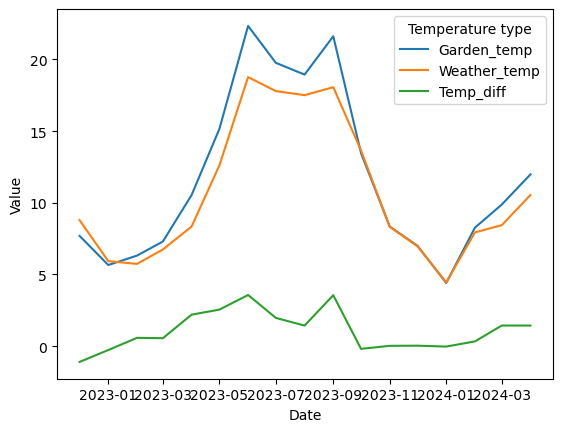

In [12]:
temp_diff_long.sort_values('Date', inplace=True)
graph = sns.lineplot(temp_diff_long, x = 'Date', y = 'Value', hue = 'Temperature type')


graph

Now, let's put garden air temperature and the weather data together in a table and run a linear model to check the influence of the variables on garden temperature.

In [13]:
weather_all = weather_df.groupby(["year", "month"])[["temperature_2m_°C", "relativehumidity_2m_%", "rain_mm", "snowfall_cm", "windspeed_10m_km/h", "winddirection_10m_°", "soil_temperature_0_to_7cm_°C"]].mean()
weather_all

garden_temp_weather_all = pd.concat([garden_air_temp, weather_all], axis=1, join='outer')
garden_temp_weather_all = garden_temp_weather_all.rename({'value': 'garden_temp'}, axis = 'columns')
garden_temp_weather_all

garden_temp  temperature_2m_°C  relativehumidity_2m_%   rain_mm  \
year month                                                                    
2022 12        7.691233           8.792361              86.973094  0.242593   
2023 1         5.658905           5.929503              84.559229  0.165591   
     2         6.315079           5.736458              85.240882  0.031399   
     3         7.300399           6.745699              80.898808  0.154167   
     4        10.542215           8.344444              77.393002  0.141806   
     5        15.153261          12.606116              78.764254  0.112366   
     6        22.339080          18.770347              66.619233  0.020694   
     7        19.762844          17.793145              75.658418  0.169624   
     8        18.943090          17.509677              80.021714  0.125269   
     9        21.617424          18.064861              80.384726  0.135833   
     10       13.461332          13.650605              83.678969  0.210484   
     11        8.341631           8.320625              84.500854  0.253889   
     12        6.997864           6.966599              86.186536  0.159946   
2024 1         4.406802           4.436694              79.315280  0.097446   
     2         8.266185           7.936566              87.515795  0.195402   
     3         9.876665           8.438911              81.150259  0.087769   
     4        11.981720          10.545549              76.770904  0.154545   

            snowfall_cm  windspeed_10m_km/h  winddirection_10m_°  \
year month                                                         
2022 12        0.000000           26.289911           219.239220   
2023 1         0.009785           21.757424           195.852630   
     2         0.001146           16.617433           200.856918   
     3         0.015618           19.896460           206.014765   
     4         0.000000           16.332988           169.993456   
     5         0.000000           14.306536           147.841973   
     6         0.000000           14.765111           140.140882   
     7         0.000000           19.094771           233.459547   
     8         0.000000           15.185336           220.036233   
     9         0.000000           12.915179           168.094086   
     10        0.000000           18.799049           198.111291   
     11        0.008458           21.757905           214.886433   
     12        0.004234           23.838774           211.871472   
2024 1         0.004328           21.341045           197.220880   
     2         0.000704           20.968848           206.384584   
     3         0.000188           16.561015           189.467507   
     4         0.005436           22.306612           223.861420   

            soil_temperature_0_to_7cm_°C  
year month                                
2022 12                         7.712963  
2023 1                          5.587500  
     2                          5.700446  
     3                          6.576882  
     4                          8.913333  
     5                         13.811828  
     6                         20.351389  
     7                         18.695632  
     8                         18.208737  
     9                         18.100486  
     10                        13.488374  
     11                         8.055417  
     12                         6.429503  
2024 1                          4.138978  
     2                          7.577874  
     3                          8.485417  
     4                         10.864205

In [14]:
X = garden_temp_weather_all.drop('garden_temp',axis= 1) 
y = garden_temp_weather_all['garden_temp'] 
print(X) 
print(y)


            temperature_2m_°C  relativehumidity_2m_%   rain_mm  snowfall_cm  \
year month                                                                    
2022 12              8.792361              86.973094  0.242593     0.000000   
2023 1               5.929503              84.559229  0.165591     0.009785   
     2               5.736458              85.240882  0.031399     0.001146   
     3               6.745699              80.898808  0.154167     0.015618   
     4               8.344444              77.393002  0.141806     0.000000   
     5              12.606116              78.764254  0.112366     0.000000   
     6              18.770347              66.619233  0.020694     0.000000   
     7              17.793145              75.658418  0.169624     0.000000   
     8              17.509677              80.021714  0.125269     0.000000   
     9              18.064861              80.384726  0.135833     0.000000   
     10             13.650605              83.678969

In [15]:
lm = LinearRegression().fit(X, y)
print(lm.score(X, y))
print(lm.coef_)

lm.intercept_

0.9924980906335592
[ 1.0207724  -0.1026695   1.10854101 -4.53363706 -0.17456128 -0.00576912
  0.02276587]


13.206941452190112

According to the linear model, snowfall had the highest influence on garden temperature, however in reality, snowfall is caused by low temperatures freezing rainfall, thus this effect can be largely ignored.
Next up are the effects of temperature at 2 meters above ground measured in the area, and rainfall. The first one is to be expected as garden temperature is obviously highly correlated with temperature of the area,
whereas the effect of rain could be explained by increase in evaporation on ground's surface that goes together with an increase in temperature, in which case, it would also rather be more of a result of temperature
instead of its cause.

Due to time constraints, the only sensor measurement looked at here was garden air temperature. Future analysis could further explore how data on humidity, etc. measured by the garden sensors differs from the data provided by the openweathermap script, and how those measurements affects garden temperature.